Pour ce notebook, nous allons regarder une méthode plus complexe que la méthode naïve qui est celle du Q-Learning. \
Le Q-Learning est une méthode d'apprentissage par renforcement qui permet d'apprendre une politique optimale dans un environnement donné. \
Cette méthode utilise un tableau de données appelé Q-Table qui va contenir les valeurs de récompense pour chaque action possible dans chaque état possible. \
L'agent va alors apprendre à choisir l'action qui lui permettra d'obtenir la plus grande récompense possible. \
Pour cela, il va utiliser une fonction de récompense qui va lui permettre de mettre à jour les valeurs de la Q-Table.

## 1. Importation des librairies

In [1]:
import gymnasium as gym # environnement.
import pickle # sauvegarde de notre modèle.
import matplotlib.pyplot as plt # affichage des graphiques.
import numpy as np # manipulation de matrices.
import itertools # manipulation de listes.
import pandas as pd # manipulation de dataframes.
import seaborn as sns # affichage des graphiques.
from tools import * # fonctions utiles.

## 2. Création de l'environnement et de la Q-Table

In [2]:
# Crée l'environnement blackjack.
# natural = True : Si le joueur fait 21 avec deux cartes (As + 10), il obtient une reward plus élevée.
# sab = True : natural est ignoré (reward de 1 même si 21 avec deux cartes) et si le joueur ainsi que le croupier font 21, il s'agira d'un match nul.
env = gym.make('Blackjack-v1', natural=False, sab=True)

# Crée un dictionnaire contenant toutes les combinaisons possibles de l'espace d'observation et d'action.
# obs_act = [(observation[0], observation[1], observation[2], action, 0)] où pour chaque élément, nous prenons toutes les possibilités.
obs_act = list(itertools.product(range(1, env.observation_space[0].n + 1, 1), range(1, env.observation_space[1].n + 1, 1), range(env.observation_space[2].n), range(env.action_space.n)))
Q = dict(zip(obs_act, np.zeros(len(obs_act), dtype=np.float64)))

# Sans bouclier

## 3. Entrainement de l'agent

In [3]:
# Paramètres pour l'entrainement.
total_train_episodes = 100_000
alpha = 0.2
gamma = 0.3
epsilon_schedule = creation_epsilon_schedule(total_train_episodes)

for episode in range(total_train_episodes):

    # Début de notre environnement pour le résoudre.
    first_obs = env.reset()[0]
    action = action_train(env, Q, first_obs, epsilon_schedule[episode], False)
    second_obs, reward, done, _, _ = env.step(action)
    update_Q_Table(alpha, gamma, Q, reward, first_obs, action, second_obs)

    # Boucle pour éxécuter plusieurs actions si nécessaire jusqu'à ce que le jeu soit terminé.
    while not done:
        action = action_train(env, Q, second_obs, epsilon_schedule[episode], False)
        next_obs, reward, done, _, _ = env.step(action)
        update_Q_Table(alpha, gamma, Q, reward, second_obs, action, next_obs)
        second_obs = next_obs

env.close()

## 4. Visualisation de la Q-Table

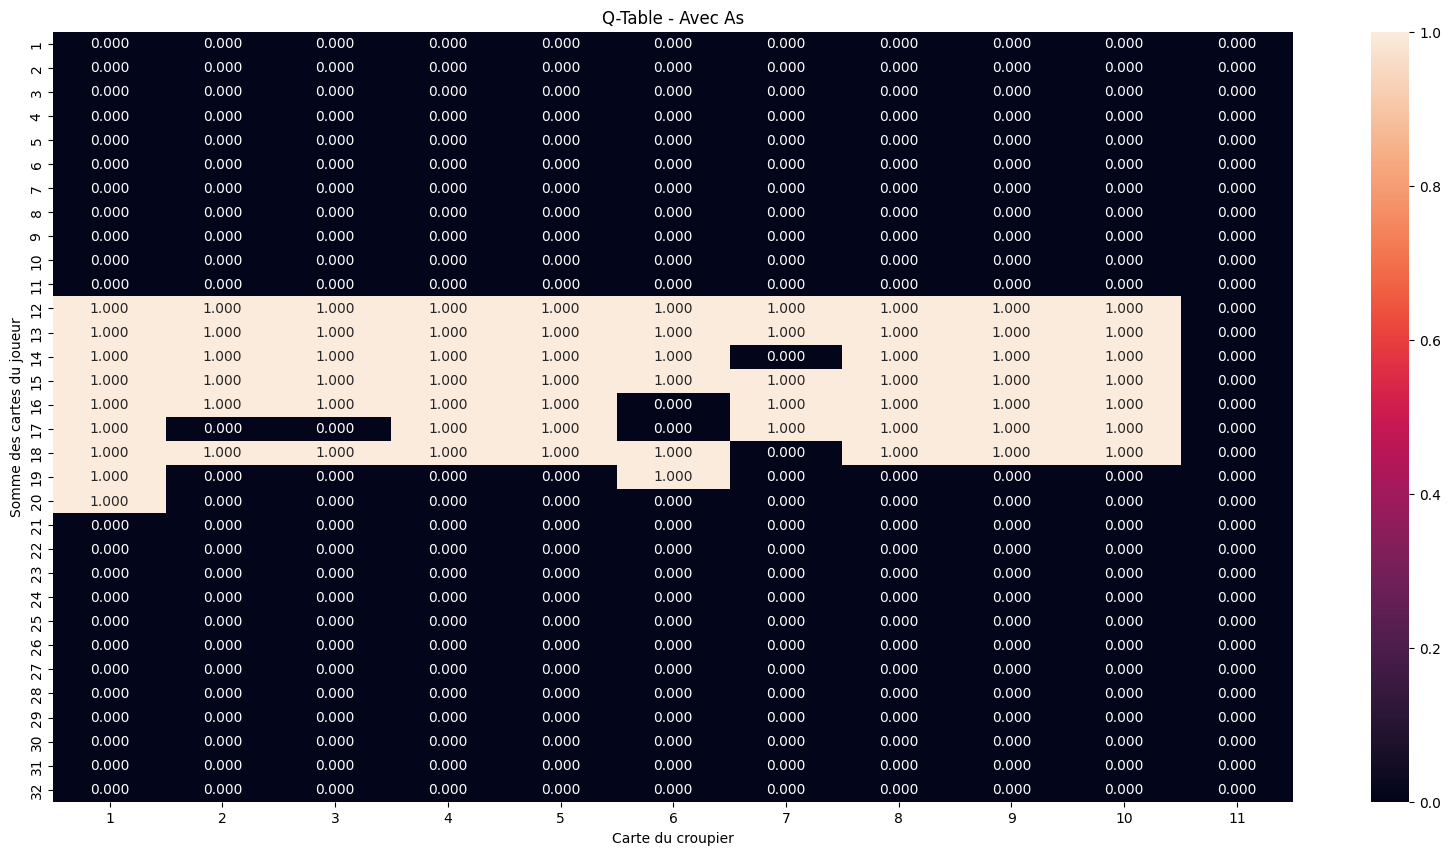

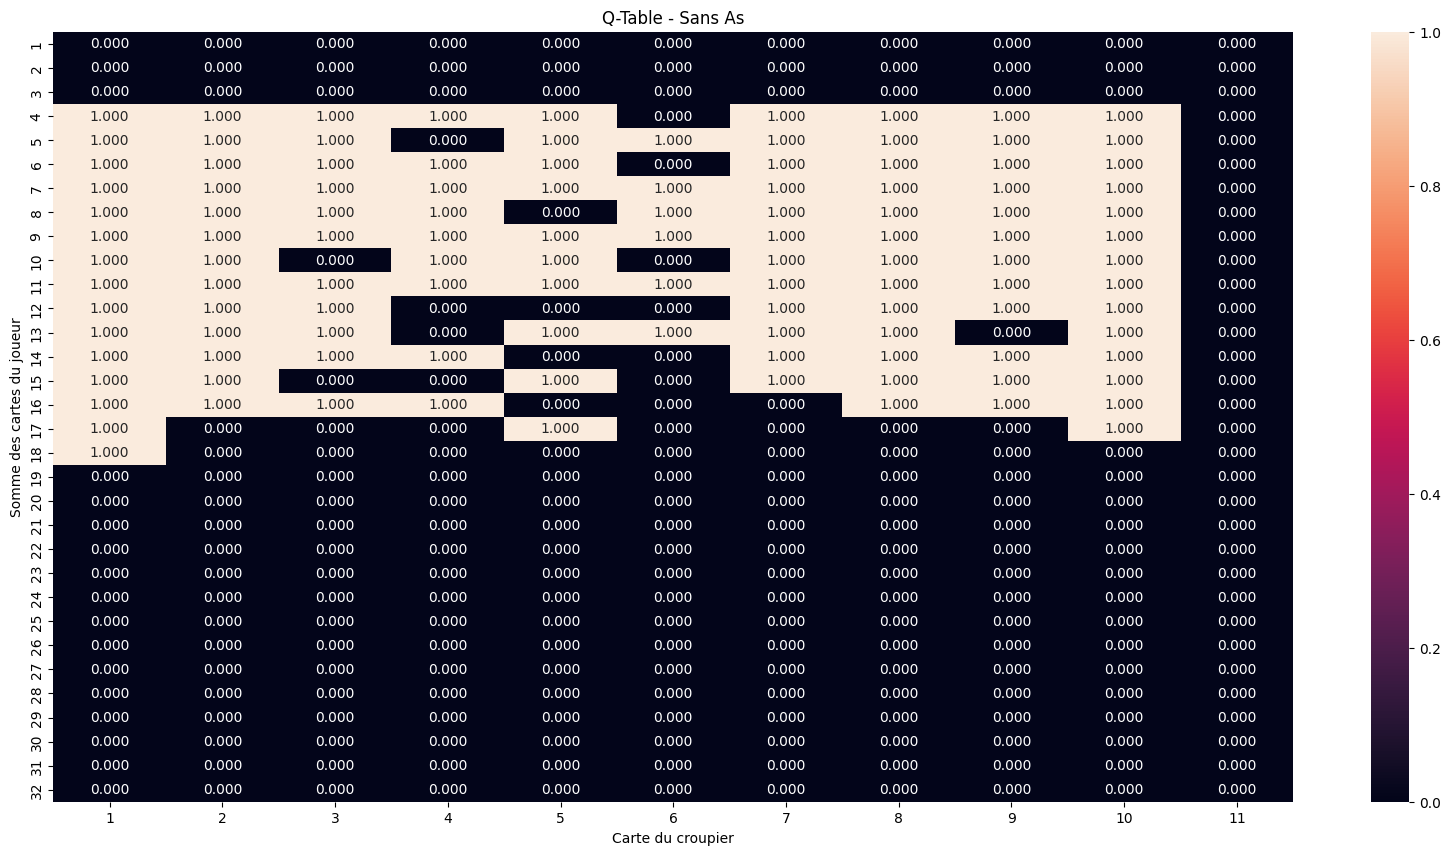

In [4]:
# Visualisation de la Q-table à partir d'une heatmap.
# Dataframe pour la Q-table avec As et sans As.
data_wAce = pd.DataFrame(np.zeros((env.observation_space[0].n, env.observation_space[1].n)), index=range(1, env.observation_space[0].n + 1), columns=range(1, env.observation_space[1].n + 1))
data_nAce = pd.DataFrame(np.zeros((env.observation_space[0].n, env.observation_space[1].n)), index=range(1, env.observation_space[0].n + 1), columns=range(1, env.observation_space[1].n + 1))

# Remplissage des dataframes.
for i in range(1, 12):
    for j in range(1, 33):
        data_wAce[i][j] = max_Q(Q, (j, i, 1))
        data_nAce[i][j] = max_Q(Q, (j, i, 0))

# Plot de la Q-table avec As.
plt.figure(figsize=(20, 10))
sns.heatmap(data_wAce, annot=True, fmt='.3f')
plt.title('Q-Table - Avec As')
plt.xlabel('Carte du croupier')
plt.ylabel('Somme des cartes du joueur')
plt.show()

# Plot de la Q-table sans As.
plt.figure(figsize=(20, 10))
sns.heatmap(data_nAce, annot=True, fmt='.3f')
plt.title('Q-Table - Sans As')
plt.xlabel('Carte du croupier')
plt.ylabel('Somme des cartes du joueur')
plt.show()

## 5. Sauvegarde de la Q-Table

In [5]:
# Permet de sauvegarder notre Q-Table dans un fichier.
with open("QTable_noshield.pkl", "wb") as f:
    pickle.dump(Q, f)

## 6. Chargement de la Q-Table

In [6]:
# Permet de charger notre Q-Table depuis un fichier.
with open("QTable_noshield.pkl", "rb") as f:
    Q = pickle.load(f)

## 7. Test de notre Agent

In [7]:
# Paramètres pour le test.
total_test_episodes = 100_000
total_win = 0
total_loose = 0
total_draw = 0

for episode in range(total_test_episodes):

    # Début de notre environnement pour le résoudre.
    first_obs = env.reset()[0]
    action = action_test(Q, first_obs)
    second_obs, reward, done, _, _ = env.step(action)

    # Boucle pour éxécuter plusieurs actions si nécessaire jusqu'à ce que le jeu soit terminé.
    while not done:
        action = action_test(Q, second_obs)
        next_obs, reward, done, _, _ = env.step(action)

    # Compréhension du résultat du jeu.
    if reward == 1:
        total_win += 1
    elif reward == -1:
        total_loose += 1
    else:
        total_draw += 1

env.close()

## 8. Interprétation des résultats

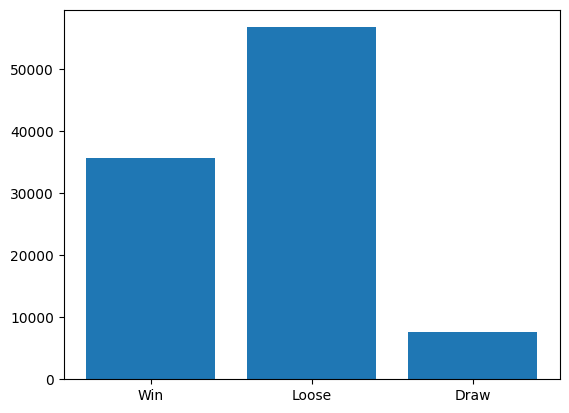

Win : 35.705 %
Loose : 56.696999999999996 %
Draw : 7.598000000000001 %


In [8]:
barplot(total_win, total_loose, total_draw, total_test_episodes) # Voir fichier tools.py

# Avec bouclier

In [9]:
Q = dict(zip(obs_act, np.zeros(len(obs_act), dtype=np.float64))) # Initialisation de la Q-Table.

## 9. Entrainement de l'agent

In [10]:
# Paramètres pour l'entrainement.
total_train_episodes = 100_000
alpha = 0.2
gamma = 0.3
epsilon_schedule = creation_epsilon_schedule(total_train_episodes)

for episode in range(total_train_episodes):

    # Début de notre environnement pour le résoudre.
    first_obs = env.reset()[0]
    action = action_train(env, Q, first_obs, epsilon_schedule[episode], True)
    second_obs, reward, done, _, _ = env.step(action)
    update_Q_Table(alpha, gamma, Q, reward, first_obs, action, second_obs)

    # Boucle pour éxécuter plusieurs actions si nécessaire jusqu'à ce que le jeu soit terminé.
    while not done:
        action = action_train(env, Q, second_obs, epsilon_schedule[episode], True)
        next_obs, reward, done, _, _ = env.step(action)
        update_Q_Table(alpha, gamma, Q, reward, second_obs, action, next_obs)
        second_obs = next_obs

env.close()

## 10. Visualisation de la Q-table

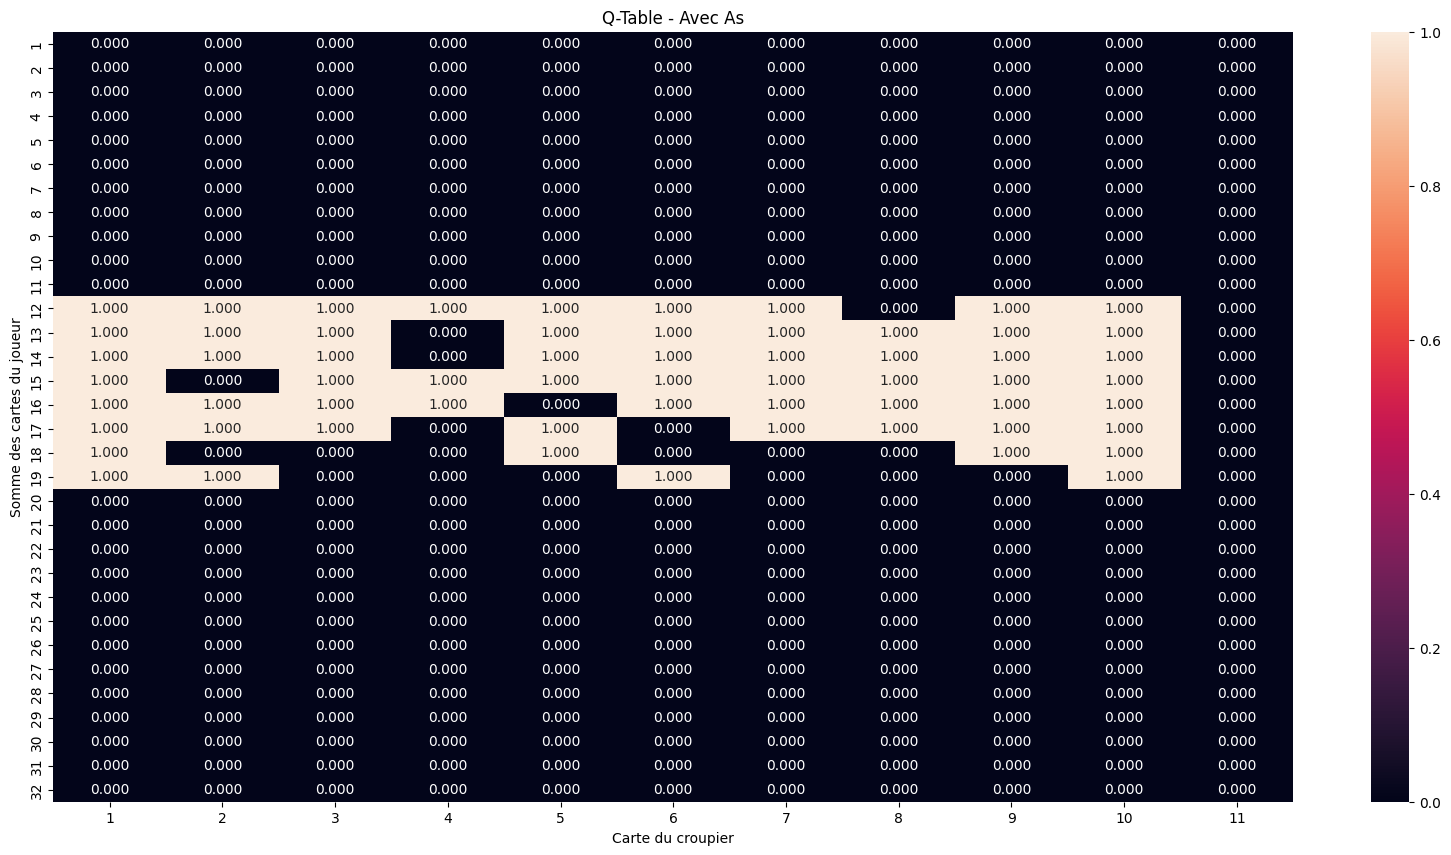

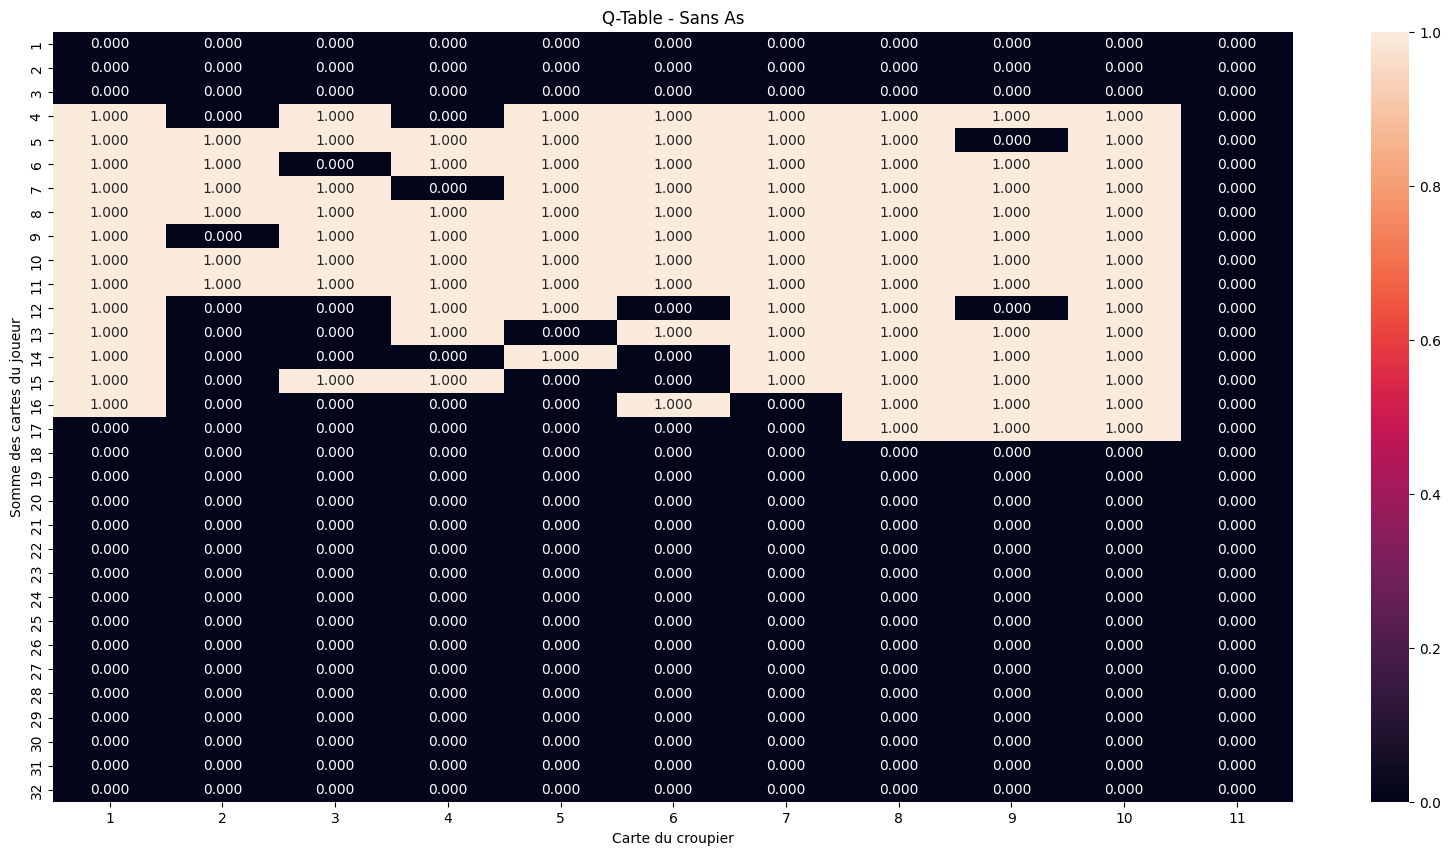

In [11]:
# Visualisation de la Q-table à partir d'une heatmap.
# Dataframe pour la Q-table avec As et sans As.
data_wAce = pd.DataFrame(np.zeros((env.observation_space[0].n, env.observation_space[1].n)), index=range(1, env.observation_space[0].n + 1), columns=range(1, env.observation_space[1].n + 1))
data_nAce = pd.DataFrame(np.zeros((env.observation_space[0].n, env.observation_space[1].n)), index=range(1, env.observation_space[0].n + 1), columns=range(1, env.observation_space[1].n + 1))

# Remplissage des dataframes.
for i in range(1, 12):
    for j in range(1, 33):
        data_wAce[i][j] = max_Q(Q, (j, i, 1))
        data_nAce[i][j] = max_Q(Q, (j, i, 0))

# Plot de la Q-table avec As.
plt.figure(figsize=(20, 10))
sns.heatmap(data_wAce, annot=True, fmt='.3f')
plt.title('Q-Table - Avec As')
plt.xlabel('Carte du croupier')
plt.ylabel('Somme des cartes du joueur')
plt.show()

# Plot de la Q-table sans As.
plt.figure(figsize=(20, 10))
sns.heatmap(data_nAce, annot=True, fmt='.3f')
plt.title('Q-Table - Sans As')
plt.xlabel('Carte du croupier')
plt.ylabel('Somme des cartes du joueur')
plt.show()

## 11. Sauvegarde de la Q-Table

In [12]:
# Permet de sauvegarder notre Q-Table dans un fichier.
with open("QTable_withshield.pkl", "wb") as f:
    pickle.dump(Q, f)

## 12. Chargement de la Q-table

In [13]:
# Permet de charger notre Q-Table depuis un fichier.
with open("QTable_withshield.pkl", "rb") as f:
    Q = pickle.load(f)

## 13. Test de notre Agent

In [14]:
# Paramètres pour le test.
total_test_episodes = 100_000
total_win = 0
total_loose = 0
total_draw = 0

for episode in range(total_test_episodes):

    # Début de notre environnement pour le résoudre.
    first_obs = env.reset()[0]
    action = action_test(Q, first_obs)
    second_obs, reward, done, _, _ = env.step(action)

    # Boucle pour éxécuter plusieurs actions si nécessaire jusqu'à ce que le jeu soit terminé.
    while not done:
        action = action_test(Q, second_obs)
        next_obs, reward, done, _, _ = env.step(action)

    # Compréhension du résultat du jeu.
    if reward == 1:
        total_win += 1
    elif reward == -1:
        total_loose += 1
    else:
        total_draw += 1

env.close()

## 14. Interprétation des résultats

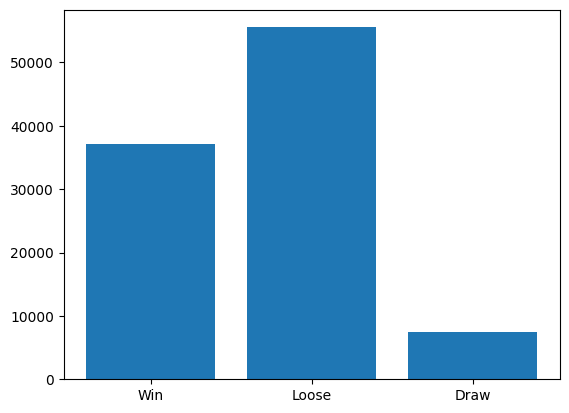

Win : 37.07 %
Loose : 55.538 %
Draw : 7.392 %


In [15]:
barplot(total_win, total_loose, total_draw, total_test_episodes) # Voir fichier tools.py